In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# The jupyter notebook for analyzing the datasets
We will analyze the datasets for potentially missing values, correlated columns and other parameters which needs to be taken into account during next phases.

We have an option to read those files:
- Monday-WorkingHours: file with traffic which belongs to normal users only
- Any other file: contains possible malicious traffic with different attacks 

In [4]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"datasets/CSVs/{dataset_files[index]}"

    with open(read_file, "r") as f:
        lines = f.readlines()

    lines[0] = lines[0].replace(", ", ",")

    with open(read_file, "w") as f:
        f.writelines(lines)

    df_read = pd.read_csv(read_file)
    pattern = r'[^\w\s]'
    df_read['Label'] = df_read['Label'].replace(pattern, '', regex=True)
    df_read.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df_read

df = dataset_file_to_df(5, files)
df["Label"].value_counts()

Label
BENIGN    189067
Bot         1966
Name: count, dtype: int64

## Check for any missing values in dataset
We will check for any missing values and decide if intervention is needed. We will also decide how to fill those missing values. For example here in first dataset, we have missing values in column Flow Bytes/s - we will come back to this later

In [5]:
missing_values = df.isna().sum()
print(missing_values[missing_values > 0]) # Check for any columns where value is missing

Series([], dtype: int64)


# Distribution and normalization
The next step is to check the distribution of variables and then normalize them

In [6]:

def print_hist(dataframe):
    num_cols = dataframe.select_dtypes(include=['number']).columns.tolist()
    # Define number of columns
    n_cols = 2

    # Determine number of rows based on the number of numeric columns
    n_rows = -(-len(num_cols) // n_cols)  # Equivalent to math.ceil(len(numeric_columns) / n_cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))  # Adjust fig size as needed
    axes = axes.flatten()  # Flatten to iterate easily

    # Plot histograms
    for i, column in enumerate(num_cols):
        dataframe[column].hist(ax=axes[i], bins=100)
        axes[i].set_title(column)

    plt.tight_layout()
    plt.show()

# print_hist(df)

In [7]:
import warnings
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
df_norm = df.copy()
for col in numeric_columns:
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)  # Convert warnings to errors

            if df[col].skew() > 0 or col == "Src Port":
                df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
            elif df[col].skew() < 0:
                df_norm[col] = df[col] ** 2  # Can cause overflow

    except RuntimeWarning as w:  # Now it will catch this!
        print(f"RuntimeWarning in column {col}: {w}")
    except Exception as e:
        print(f"An error occurred while processing column {col}: {e}")

def compare_hists(df1, df2, cols):
    n_cols = 2  # Each row has 2 plots: one from df1, one from df2
    n_rows = len(cols)  # Each feature gets its own row

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))

    for i, column in enumerate(cols):
        # Plot df1[col] on the left
        df1[column].hist(ax=axes[i, 0], bins=100, alpha=0.5, color='blue', label="df1")
        axes[i, 0].set_title(f"{column} (df1)")

        # Plot df2[col] on the right
        df2[column].hist(ax=axes[i, 1], bins=100, alpha=0.5, color='orange', label="df2")
        axes[i, 1].set_title(f"{column} (df2)")

        # Add legends
        axes[i, 0].legend()
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


#compare_hists(df, df_norm, numeric_columns)


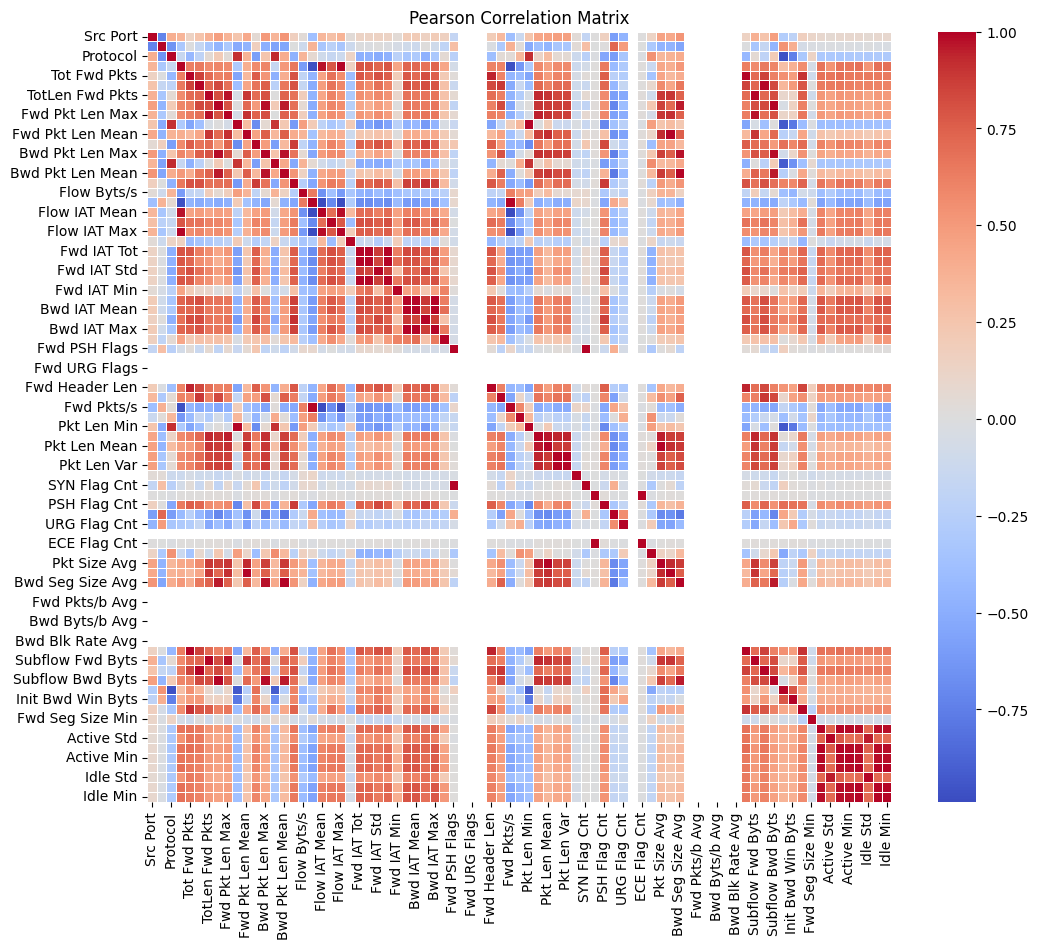

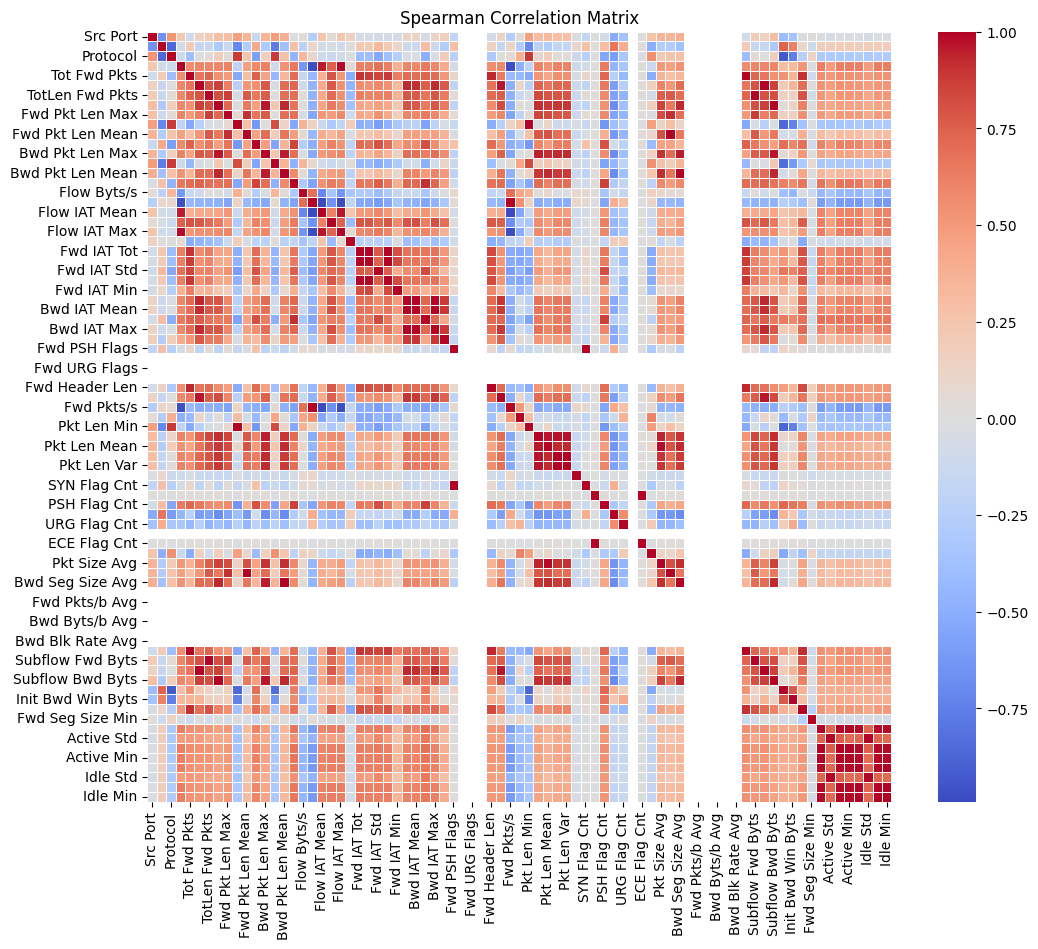

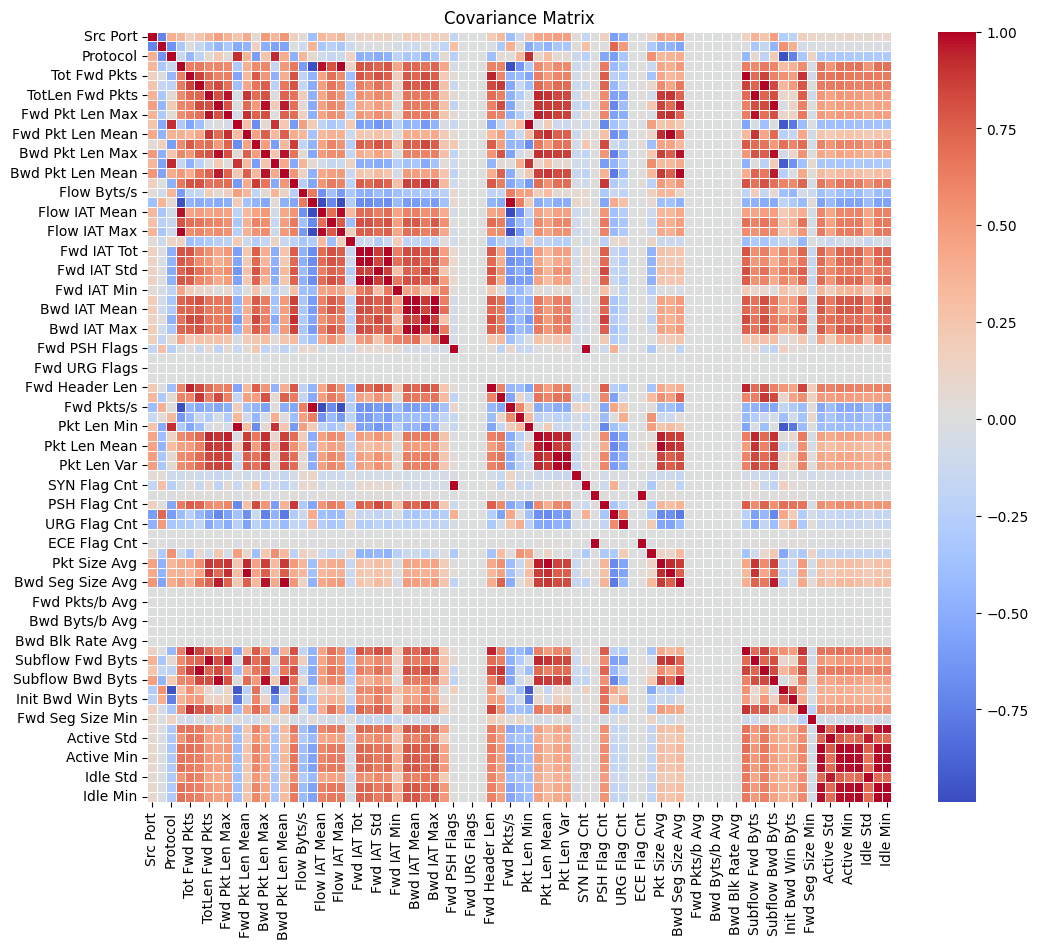

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df_norm.drop(["Label", "Flow ID", "Src IP", "Dst IP", "Timestamp"], axis=1)
# ...existing code...

from sklearn.feature_selection import mutual_info_classif

# Calculate Pearson correlation matrix
pearson_corr_matrix = X.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()

# Calculate Spearman correlation matrix
spearman_corr_matrix = X.corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()



y = df_norm["Label"]
y_bin = y.apply(lambda x: 1 if x == "BENIGN" else 0)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.3, random_state=42, stratify=y_bin)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()

X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)


cov_matrix = pd.DataFrame(X_train_bin_scaled, columns=X.columns).cov()  # Obliczenie macierzy kowariancji
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix")
plt.show()

pca = PCA()

pca.fit(X_train_bin_scaled)

# Get explained variance ratio (how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)




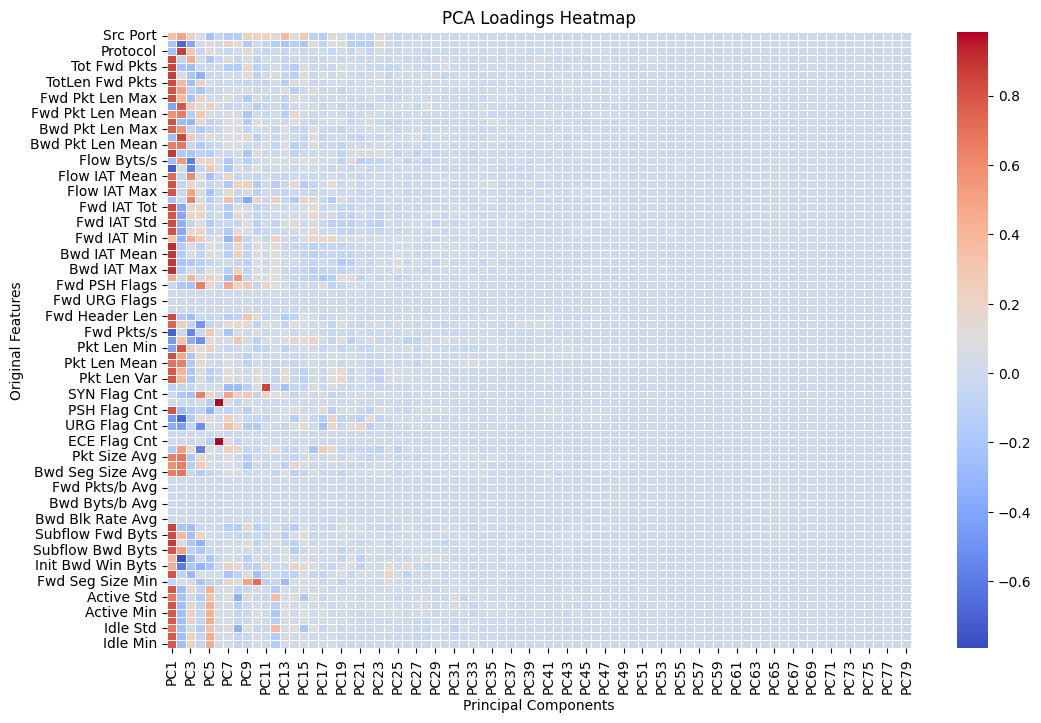

Top contributing features for each principal component:

PC1:
Bwd IAT Tot         0.919534
Bwd IAT Max         0.909981
Bwd IAT Mean        0.893230
Bwd IAT Std         0.888432
Bwd Pkt Len Std     0.886961
Subflow Bwd Pkts    0.873275
Tot Bwd Pkts        0.873275
Tot Fwd Pkts        0.856971
Subflow Fwd Pkts    0.856971
Fwd IAT Tot         0.843836
Name: PC1, dtype: float64

PC2:
Protocol            0.870608
Bwd Pkt Len Min     0.845576
Pkt Len Min         0.799618
Fwd Pkt Len Min     0.794976
Bwd Pkt Len Mean    0.684687
Bwd Seg Size Avg    0.684687
Pkt Size Avg        0.678727
Fwd Seg Size Avg    0.663422
Fwd Pkt Len Mean    0.663422
Pkt Len Mean        0.645599
Name: PC2, dtype: float64

PC3:
Flow IAT Min       0.632982
Flow IAT Mean      0.597891
Flow IAT Max       0.498522
Fwd IAT Min        0.466810
Flow Duration      0.451820
Bwd IAT Min        0.411439
Protocol           0.308843
Bwd Pkt Len Min    0.287578
Fwd Pkt Len Min    0.276261
Pkt Len Min        0.274950
Name: PC3, dty

In [11]:

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, index=X.columns, columns=[f"PC{i+1}" for i in range(loadings.shape[1])])

# Plot heatmap of loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("PCA Loadings Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.show()

# Print top contributing features for the first few principal components
print("Top contributing features for each principal component:")
for i in range(min(5, loadings_df.shape[1])):  # Adjust the range as needed
    print(f"\nPC{i+1}:")
    print(loadings_df.iloc[:, i].sort_values(ascending=False).head(10))

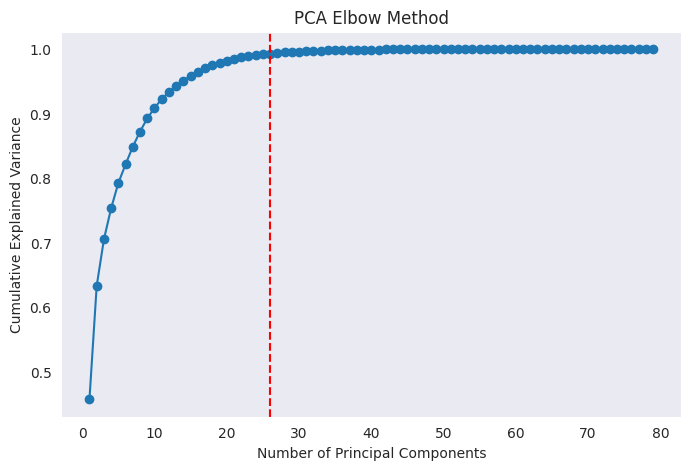

Optimal number of components: 26


In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [21]:
pca = PCA(n_components=elbow_point)
X_train_bin_pca = pca.fit_transform(X_train_bin_scaled)
X_test_bin_pca = pca.transform(X_test_bin_scaled)



Training Accuracy: 0.9969115260650748
Test Accuracy: 0.9969987785726749


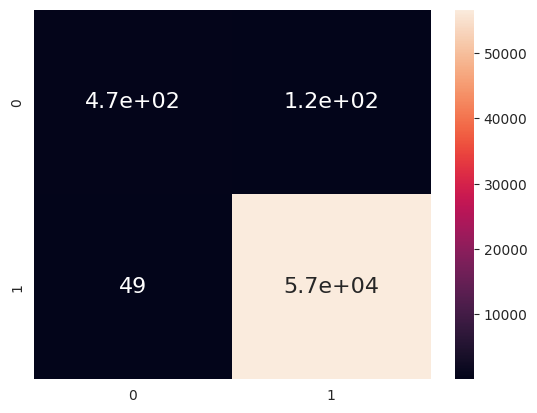

Precision: 0.9978342782688312
Recall: 0.9991361071932299
F1 Score: 0.9984847683986117


In [22]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_bin_pca, y_train_bin)

print("Training Accuracy:", log_reg.score(X_train_bin_pca, y_train_bin))
print("Test Accuracy:", log_reg.score(X_test_bin_pca, y_test_bin))


y_pred = log_reg.predict(X_test_bin_pca)
cnf_matrix = confusion_matrix(y_test_bin, y_pred)
df_cm = pd.DataFrame(cnf_matrix, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

print('Precision:', precision_score(y_test_bin, y_pred))
print('Recall:', recall_score(y_test_bin, y_pred))
print('F1 Score:', f1_score(y_test_bin, y_pred))


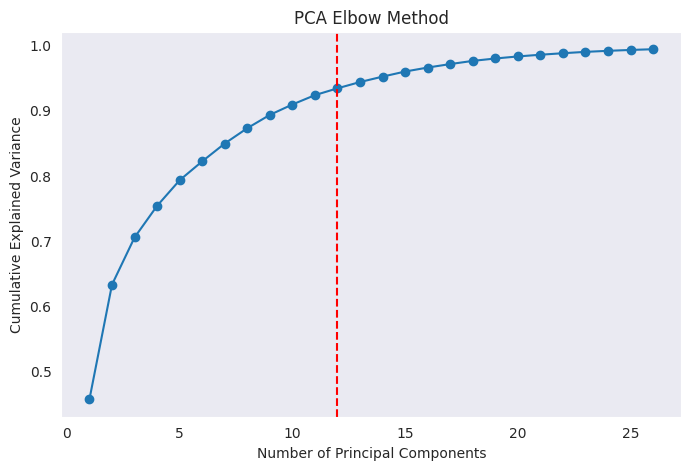

Optimal number of components: 12


In [25]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=26)

pca.fit(X_train_scaled)

# Get explained variance ratio (how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.01) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

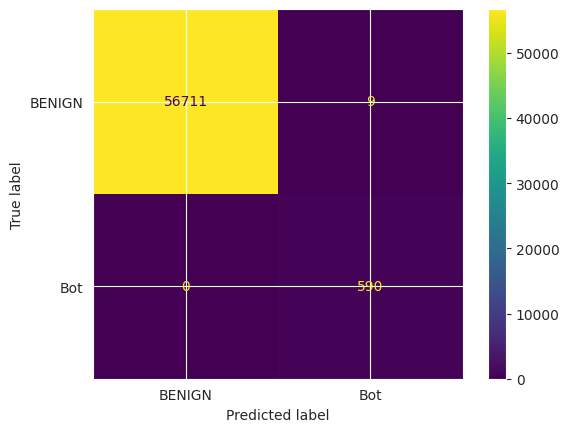

Precision: 0.9924874791318865
Recall: 0.9999206629055006
F1 Score: 0.9961756352859694


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=knn.classes_)
disp.plot()
plt.show()

print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))